# Deep Learning With Apache Spark

### Loading Spark-DL into the notebook


In [1]:
# pip install tensorflow==1.15
import os
SUBMIT_ARGS = "--packages databricks:spark-deep-learning:1.0.0-spark2.3-s_2.11 pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("DL with Spark Deep Cognition").getOrCreate()
sc = spark.sparkContext
print(sc)

<SparkContext master=local[*] appName=DL with Spark Deep Cognition>


### Image Loading

Let's do a sample image recognition using Deep Learning, but loading some images into Spark

In [ ]:
# !curl -O http://download.tensorflow.org/example_images/flower_photos.tgz
# !tar xzf flower_photos.tgz
# ! rm flower_photos.tgz
# !mkdir flower_photos/sample
# !cp flower_photos/daisy/100080576_f52e8ee070_n.jpg flower_photos/sample/
# !cp flower_photos/daisy/10140303196_b88d3d6cec.jpg flower_photos/sample/
# !cp flower_photos/tulips/100930342_92e8746431_n.jpg flower_photos/sample/

### Display a few images

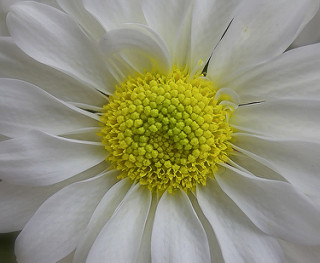

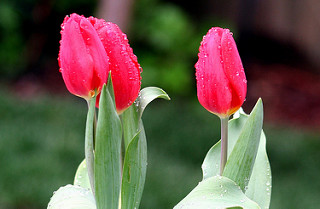

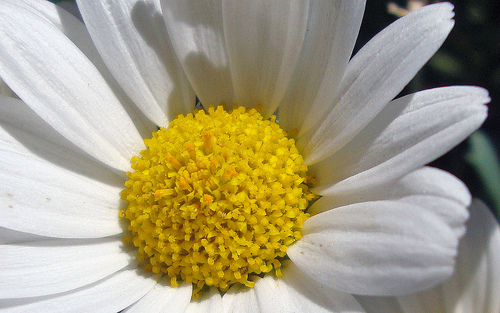

Done


In [2]:
from IPython.display import display_png, Image, display
import os

path = '/home/student/ROI/Spark/flower_photos/'
files = os.listdir(path + 'sample/')
images = [Image(filename = path + 'sample/' + file, format = 'png') for file in files if file.endswith('.jpg')]
for ea in images:
    display_png(ea)

print ('Done')

### Read images into a Spark DataFrame

In [3]:
from pyspark.ml.image import ImageSchema
image_df = ImageSchema.readImages(path + "sample/")
image_df.printSchema()
image_df.take(1)
display(image_df)


root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)



DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>]

### We need to install TensorFlow and keras but for this demo we need an older version of TensorFlow
We split up the dataets as we normally would into training and testing sets

In [4]:
# !pip install tensorflow==1.15
# !pip install keras

from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit
from sparkdl.image import imageIO

tulips_df = ImageSchema.readImages(path + "tulips/").withColumn("label", lit(1))
daisy_df = ImageSchema.readImages(path + "daisy/").withColumn("label", lit(0))
#daisy_df = imageIO.readImagesWithCustomFn(path + "daisy/", decode_f=imageIO.PIL_decode) \
#           .withColumn("label", lit(0))

tulips_train, tulips_test, _ = tulips_df.randomSplit([0.1, 0.05, 0.85])  # use larger training sets (e.g. [0.6, 0.4] for getting more images)
daisy_train, daisy_test, _ = daisy_df.randomSplit([0.1, 0.05, 0.85])     # use larger training sets (e.g. [0.6, 0.4] for getting more images)

train_df = tulips_train.unionAll(daisy_train)
test_df = tulips_test.unionAll(daisy_test)

display(train_df)
# train_df.cache()
# test_df.cache()
print(train_df.take(1))

# Under the hood, each of the partitions is fully loaded in memory, which may be expensive.
# This ensure that each of the paritions has a small size.
#train_df = train_df.repartition(100)
#test_df = test_df.repartition(100)
print ('Done')

Using TensorFlow backend.


DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>, label: int]

[Row(image=Row(origin='file:/home/student/ROI/Spark/flower_photos/tulips/10995953955_089572caf0.jpg', height=332, width=500, nChannels=3, mode=16, data=bytearray(b'%)<\x1b8< -%*\x0f::[M\'\'!\x9c8b\xff\xc6\xcb\xe4\xab\xb4\xe9\xb0\xa7\xe3\xaf\xaf\xeb\xaf\xa9\xde\xae\xaa\xdf\xaf\xab\xe0\xac\xac\xe1\xb6\xa7\xe5\xb3\xad\xe6\xb5\xad\xe7\xb5\xaf\xe9\xb7\xb1\xe5\xb5\xb1\xe8\xb8\xb2\xe9\xbb\xb0\xeb\xb5\xbc\xed\xba\xb7\xea\xb9\xb7\xeb\xbc\xb8\xf0\xbd\xc1\xee\xb9\xbc\xea\xbf\xb6\xeb\xc1\xbc\xf5\xbd\xbc\xed\xbe\xc1\xf3\xc4\xc0\xf6\xc3\xc0\xed\xc3\xc4\xf6\xc7\xca\xf7\xcb\xca\xfa\xca\xc6\xf0\xc3\xc0\xf3\xc4\xc0\xf5\xc4\xc2\xf8\xc6\xc0\xf5\xc3\xc5\xf6\xc7\xc9\xf3\xc9\xc2\xf8\xcc\xcb\xf8\xc9\xcb\xfa\xca\xd0\xfc\xcd\xd0\xf7\xcb\xca\xfa\xce\xcf\xf8\xcb\xce\xf7\xc8\xcb\xf9\xca\xcd\xf7\xc7\xc5\xff\xcb\xce\xf3\xc9\xbd\xfa\xc7\xcb\xf9\xc6\xc3\xf8\xcc\xc5\xf1\xcb\xc7\xf2\xce\xbe\xf9\xc8\xca\xf7\xc9\xcf\xff\xca\xc7\xfb\xed\xe7jaT\x14(:-EEhX_857\x1f:7\x18>8(?A*L;\x1e01\x1e\'$\x10-6 @F(FK"RX\x1a?75B:\x1d>0+6:,F

In [ ]:
train_df.unpersist()
test_df.unpersist()


### Let’s train the model

In [5]:
# nano /etc/java-11-openjdk/accessibility.properties
# comment out assistive_technologies=org.GNOME.Accessibility.AtkWrapper
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer 

featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features", modelName="InceptionV3")
# #display(train_df)
# x = featurizer.transform(train_df)
# # print(x.take(1))
# display(x)

lr = LogisticRegression(maxIter=10, regParam=0.05, elasticNetParam=0.3, labelCol="label")
p = Pipeline(stages=[featurizer, lr])

p_model = p.fit(train_df)
#lr1 = lr.fit(x)
print ('Done')

/home/student/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Py4JJavaError: An error occurred while calling o112.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 2.0 failed 1 times, most recent failure: Lost task 1.0 in stage 2.0 (TID 3, localhost, executor driver): java.lang.IllegalArgumentException: Numbers of source Raster bands and source color space components do not match
	at java.awt.image.ColorConvertOp.filter(ColorConvertOp.java:482)
	at com.sun.imageio.plugins.jpeg.JPEGImageReader.acceptPixels(JPEGImageReader.java:1288)
	at com.sun.imageio.plugins.jpeg.JPEGImageReader.readImage(Native Method)
	at com.sun.imageio.plugins.jpeg.JPEGImageReader.readInternal(JPEGImageReader.java:1255)
	at com.sun.imageio.plugins.jpeg.JPEGImageReader.read(JPEGImageReader.java:1058)
	at javax.imageio.ImageIO.read(ImageIO.java:1462)
	at javax.imageio.ImageIO.read(ImageIO.java:1357)
	at org.apache.spark.ml.image.ImageSchema$.decode(ImageSchema.scala:136)
	at org.apache.spark.ml.image.ImageSchema$$anonfun$readImages$2$$anonfun$apply$1$$anonfun$1.apply(ImageSchema.scala:248)
	at org.apache.spark.ml.image.ImageSchema$$anonfun$readImages$2$$anonfun$apply$1$$anonfun$1.apply(ImageSchema.scala:247)
	at org.apache.spark.ml.image.ImageSchema$$anonfun$readImages$2$$anonfun$apply$1$$anonfun$3.apply(ImageSchema.scala:253)
	at org.apache.spark.ml.image.ImageSchema$$anonfun$readImages$2$$anonfun$apply$1$$anonfun$3.apply(ImageSchema.scala:252)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at scala.collection.AbstractIterator.to(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1334)
	at org.tensorframes.impl.DebugRowOps$$anonfun$39.apply(DebugRowOps.scala:477)
	at org.tensorframes.impl.DebugRowOps$$anonfun$39.apply(DebugRowOps.scala:475)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD$$anonfun$7.apply(RDD.scala:337)
	at org.apache.spark.rdd.RDD$$anonfun$7.apply(RDD.scala:335)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$fold$1.apply(RDD.scala:1098)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1092)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1.apply(RDD.scala:1161)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1137)
	at org.apache.spark.ml.classification.LogisticRegression$$anonfun$train$1.apply(LogisticRegression.scala:520)
	at org.apache.spark.ml.classification.LogisticRegression$$anonfun$train$1.apply(LogisticRegression.scala:494)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:183)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:183)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:494)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:489)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:279)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:82)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException: Numbers of source Raster bands and source color space components do not match
	at java.awt.image.ColorConvertOp.filter(ColorConvertOp.java:482)
	at com.sun.imageio.plugins.jpeg.JPEGImageReader.acceptPixels(JPEGImageReader.java:1288)
	at com.sun.imageio.plugins.jpeg.JPEGImageReader.readImage(Native Method)
	at com.sun.imageio.plugins.jpeg.JPEGImageReader.readInternal(JPEGImageReader.java:1255)
	at com.sun.imageio.plugins.jpeg.JPEGImageReader.read(JPEGImageReader.java:1058)
	at javax.imageio.ImageIO.read(ImageIO.java:1462)
	at javax.imageio.ImageIO.read(ImageIO.java:1357)
	at org.apache.spark.ml.image.ImageSchema$.decode(ImageSchema.scala:136)
	at org.apache.spark.ml.image.ImageSchema$$anonfun$readImages$2$$anonfun$apply$1$$anonfun$1.apply(ImageSchema.scala:248)
	at org.apache.spark.ml.image.ImageSchema$$anonfun$readImages$2$$anonfun$apply$1$$anonfun$1.apply(ImageSchema.scala:247)
	at org.apache.spark.ml.image.ImageSchema$$anonfun$readImages$2$$anonfun$apply$1$$anonfun$3.apply(ImageSchema.scala:253)
	at org.apache.spark.ml.image.ImageSchema$$anonfun$readImages$2$$anonfun$apply$1$$anonfun$3.apply(ImageSchema.scala:252)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at scala.collection.AbstractIterator.to(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1334)
	at org.tensorframes.impl.DebugRowOps$$anonfun$39.apply(DebugRowOps.scala:477)
	at org.tensorframes.impl.DebugRowOps$$anonfun$39.apply(DebugRowOps.scala:475)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD$$anonfun$7.apply(RDD.scala:337)
	at org.apache.spark.rdd.RDD$$anonfun$7.apply(RDD.scala:335)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
#p_model.save('/home/student/ROI/flower.model')

In [ ]:
# from pyspark.ml import PipelineModel
# p_model2 = PipelineModel.load('/home/student/ROI/flower.model')

### Look at how well the model performs

In [ ]:
predictions = p_model.transform(test_df)
predictions.cache()

In [ ]:
#from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import IntegerType, DoubleType
# evaluator = MultiClassificationEvaluator()
# evaluator.evaluate(predictions
x = predictions.select("prediction", "label").withColumn("label", predictions["label"].cast(DoubleType()))
print(x.take(10))
metrics = MulticlassMetrics(x.rdd)
print(metrics.confusionMatrix())


### We can take look at where we are making mistakes:

In [ ]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import expr
from pyspark.sql.functions import *
from pyspark.sql.types import *

def _p1(v):
    return float(v.array[1])
take_one = udf(_p1, DoubleType())

# @udf('double')
# def take_one (v):
#     return float(v.array[1])

df = predictions.withColumn("p", take_one(predictions.probability))
wrong_df = df.orderBy(expr("abs(p - label)"), ascending=False)
#wrong_df.select("image.origin", "p", "label").show(10)
wrong_df.createOrReplaceTempView('wrong')

print('Done')

In [ ]:
x = spark.sql('select image.origin as origin, p, label from wrong order by p desc').collect()


In [ ]:
#print(x)
for label in range(2):
    for file in [f for f in x if f.label == label][:3]:
        print (file.origin[5:])
        display_png(Image(filename = file.origin[5:], format = 'png') )



### Working with general tensors

Deep Learning Pipelines also provides ways to apply models with tensor inputs
(up to 2 dimensions), written in popular deep learning libraries:

* TensorFlow graphs
* Keras models

In this article we will focus only in the Keras models. The `KerasTransformer`
applies a TensorFlow-backed Keras model to tensor inputs of up to 2 dimensions.
It loads a Keras model from a given model file path and applies the model to a
column of arrays (where an array corresponds to a Tensor), outputting a column
of arrays.

In [6]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from sparkdl import KerasTransformer
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# Generate random input data
num_features = 10
num_examples = 100
input_data = [{"features" : np.random.randn(num_features).astype(float).tolist()} for i in range(num_examples)]
schema = StructType([ StructField("features", ArrayType(FloatType()), True)])
input_df = spark.createDataFrame(input_data, schema)

# Create and save a single-hidden-layer Keras model for binary classification
# NOTE: In a typical workflow, we'd train the model before exporting it to disk,
# but we skip that step here for brevity
model = Sequential()
model.add(Dense(units=20, input_shape=[num_features], activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model_path = "simple-binary-classification"
model.save(model_path)

# Create transformer and apply it to our input data
transformer = KerasTransformer(inputCol="features", outputCol="predictions", modelFile=model_path)
final_df = transformer.transform(input_df)
print('Done')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 4 variables.
INFO:tensorflow:Converted 4 variables to const ops.
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.
Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`


/home/student/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '





Done


In [7]:
final_df.show()
print(input_df.take(1))
print(final_df.take(1))

+------------+--------------------+
| predictions|            features|
+------------+--------------------+
|[0.45659912]|[-0.86790067, 0.9...|
|[0.45907155]|[0.91950595, -0.2...|
| [0.5151138]|[-0.51296294, 0.6...|
| [0.7691458]|[-1.1565583, -2.0...|
|[0.44393244]|[1.2810333, 2.031...|
| [0.3893413]|[0.7966814, 0.787...|
|  [0.789821]|[-0.8595229, -0.6...|
| [0.7053236]|[0.31579682, -0.6...|
|[0.51643676]|[-0.39497447, 0.6...|
| [0.4641885]|[0.8153718, 1.159...|
|[0.63024306]|[0.27394682, 0.49...|
|  [0.532646]|[-0.42631647, -0....|
| [0.6608162]|[-1.0941906, 0.09...|
|[0.47967356]|[-0.685631, -0.85...|
|[0.63140553]|[0.7453412, -1.11...|
|  [0.667652]|[1.0780964, -1.33...|
| [0.6409518]|[0.60709065, -0.4...|
| [0.7564167]|[-0.68130237, -0....|
| [0.7182516]|[2.4499593, 0.245...|
| [0.5205828]|[0.07101274, -0.4...|
+------------+--------------------+
only showing top 20 rows

[Row(features=[-0.8679006695747375, 0.9214032888412476, -0.3563392162322998, -1.205376148223877, -0.2810578942

### Deploying Models in SQL

One way to productionize a model is to deploy it as a Spark SQL User Defined Function, which allows anyone who knows SQL to use it. Deep Learning Pipelines provides mechanisms to take a deep learning model and register a Spark SQL User Defined Function (UDF). In particular, Deep Learning Pipelines 0.2.0 adds support for creating SQL UDFs from Keras models that work on image data.

The resulting UDF takes a column (formatted as a image struct “SpImage”) and produces the output of the given Keras model; e.g. for Inception V3, it produces a real valued score vector over the ImageNet object categories.

In [8]:
from keras.applications import InceptionV3
from sparkdl.udf.keras_image_model import registerKerasImageUDF

registerKerasImageUDF("inceptionV3_udf", InceptionV3(weights="imagenet"))




Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.
INFO:tensorflow:Froze 378 variables.
INFO:tensorflow:Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.


IllegalArgumentException: "NodeDef mentions attr 'Truncate' not in Op<name=Cast; signature=x:SrcT -> y:DstT; attr=SrcT:type; attr=DstT:type>; NodeDef: spimg/ToFloat = Cast[DstT=DT_FLOAT, SrcT=DT_UINT8, Truncate=false](spimg/decode_raw). (Check whether your GraphDef-interpreting binary is up to date with your GraphDef-generating binary.)."

In Keras workflows dealing with images, it’s common to have preprocessing steps before the model is applied to the image. If our workflow requires preprocessing, we can optionally provide a preprocessing function to UDF registration. The preprocessor should take in a filepath and return an image array; below is a simple example.

In [9]:
from keras.applications import InceptionV3
from sparkdl.udf.keras_image_model import registerKerasImageUDF

def keras_load_img(fpath):
    from keras.preprocessing.image import load_img, img_to_array
    import numpy as np
    img = load_img(fpath, target_size=(299, 299))
    return img_to_array(img).astype(np.uint8)

registerKerasImageUDF("inceptionV3_udf_with_preprocessing", InceptionV3(weights="imagenet"), keras_load_img)
print('Done')

INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.
INFO:tensorflow:Froze 378 variables.
INFO:tensorflow:Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.


IllegalArgumentException: "NodeDef mentions attr 'Truncate' not in Op<name=Cast; signature=x:SrcT -> y:DstT; attr=SrcT:type; attr=DstT:type>; NodeDef: spimg/ToFloat = Cast[DstT=DT_FLOAT, SrcT=DT_UINT8, Truncate=false](spimg/decode_raw). (Check whether your GraphDef-interpreting binary is up to date with your GraphDef-generating binary.)."

Once a UDF has been registered, it can be used in a SQL query:

In [ ]:
from pyspark.ml.image import ImageSchema

image_df = ImageSchema.readImages("flower_photos/sample/")
image_df.registerTempTable("sample_images")

In [ ]:
display(image_df)

### Once a data scientist builds the desired model, Deep Learning Pipelines makes it simple to expose it as a function in SQL, so anyone in their organization can use it.

In [ ]:

display(spark.sql("SELECT inceptionV3_udf_with_preprocessing(image) as predictions from sample_images"))
#.show(truncate=False)

## Code below does not work

### Spark prediction pipeline using InceptionV3.

In [ ]:
from sparkdl import DeepImagePredictor
# Read images using Spark
image_df = ImageSchema.readImages("flower_photos/sample/")
predictor = DeepImagePredictor(inputCol="image", outputCol="predicted_labels", modelName="InceptionV3", decodePredictions=True, topK=10)
predictions_df = predictor.transform(image_df)
print ('Done')

### Let's take a look to the predictions dataframe:

In [ ]:
predictions_df.select("predicted_labels").show(truncate=False,n=3)

### Notice that the 'predicted_labels' column shows 'daisy' as a high probability
class for all of sample flowers using this base model,** for some reason the
tulip was closer to a picket fence than to a flower (maybe because of the
background of the photo)**. 

However, as can be seen from the differences in the probability values, the
neural network has the information to discern the two flower types. Hence our
transfer learning example above was able to properly learn the differences
between daisies and tulips starting from the base model.

Let’s see how well our model discern the type of the flower:

In [ ]:
df = p_model.transform(image_df)

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [ ]:
def _p1(v):
    return float(v.array[1])
take_one = udf(_p1, DoubleType())

In [ ]:
# 100930342_92e8746431_n.jpg not a daisy
df.select("image.origin",(1-take_one(df.probability)).alias("p_daisy")).show(truncate=False)

## For Keras 

To use the transformer, we first need to have a Keras model stored as a file. For this notebook we'll just save the Keras built-in InceptionV3 model instead of training one.

In [ ]:
from keras.applications import InceptionV3
model = InceptionV3(weights="imagenet")
model.save('model-full.h5')
print('Done')

### Now we will create a Keras transformer but first we will preprocess the images to work with it

In [ ]:
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
from pyspark.sql.types import StringType
from sparkdl import KerasImageFileTransformer

def loadAndPreprocessKerasInceptionV3(uri):
  # this is a typical way to load and prep images in keras
    image = img_to_array(load_img(uri, target_size=(299, 299)))  # image dimensions for InceptionV3
    image = np.expand_dims(image, axis=0)
    return preprocess_input(image)

transformer = KerasImageFileTransformer(inputCol="uri", outputCol="predictions",
                                        modelFile='model-full.h5',  # local file path for model
                                        imageLoader=loadAndPreprocessKerasInceptionV3,
                                        outputMode="vector")
print('Done')

### We will read now the images and load them into a Spark Dataframe and them use our transformer to apply the model into the images:

In [ ]:
fs = !ls flower_photos/sample/*.jpg

In [ ]:
fs

In [ ]:
uri_df = spark.createDataFrame(fs, StringType()).toDF("uri")

In [ ]:
uri_df.show()

In [ ]:
#dir(transformer)
keras_pred_df = transformer.transform(uri_df)

In [ ]:
keras_pred_df.select("uri", "predictions").show()